<a href="https://colab.research.google.com/github/Agapenng/Python-for-bioinformatics-Exam-code/blob/main/Data_Focus_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Research Question 1 – Health Inequalities & Public Health Behaviors**

 How do socioeconomic status (SES), ethnicity, and chronic conditions interact to shape vaccination hesitancy, compliance with health guidelines, and disease severity across different demographic groups?


In [2]:
import pandas as pd

# Load dataset
file_path = "/content/Public health data/public_health_surveillance_dataset.csv"
df = pd.read_csv(file_path)

# Focus on Gender + other key factors
subset = df[["Gender", "SES", "Ethnicity", "Chronic_Conditions", "Disease_Severity"]]

# Group by and count
gender_counts = (
    subset.groupby(["Gender", "SES", "Ethnicity", "Chronic_Conditions", "Disease_Severity"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Gender", "SES", "Ethnicity", "Chronic_Conditions", "Disease_Severity"])
)

# Show first few rows
print(gender_counts.head(15))

# Save to CSV if needed
out_file = "/content/Public health data/gender_interactions_disease_severity.csv"
gender_counts.to_csv(out_file, index=False)
print("Saved counts to:", out_file)


    Gender   SES   Ethnicity  Chronic_Conditions Disease_Severity  Count
0   Female  High  Ethnicity1                   0             Mild    422
1   Female  High  Ethnicity1                   0         Moderate    123
2   Female  High  Ethnicity1                   0           Severe     60
3   Female  High  Ethnicity1                   1             Mild    181
4   Female  High  Ethnicity1                   1         Moderate     52
5   Female  High  Ethnicity1                   1           Severe     28
6   Female  High  Ethnicity2                   0             Mild    144
7   Female  High  Ethnicity2                   0         Moderate     49
8   Female  High  Ethnicity2                   0           Severe     27
9   Female  High  Ethnicity2                   1             Mild     72
10  Female  High  Ethnicity2                   1         Moderate     16
11  Female  High  Ethnicity2                   1           Severe     11
12  Female  High  Ethnicity3                   0   

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Count SES by demographic groups

Creates raw count tables and bar charts:
- ses_counts_by_gender.csv / .png
- ses_counts_by_ethnicity.csv / .png
- ses_counts_by_location_top12.csv / .png
"""

import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# -------------------- CONFIG --------------------
DATA_PATH = "/content/Public health data/public_health_surveillance_dataset.csv"
OUTDIR = Path("ses_counts")
OUTDIR.mkdir(parents=True, exist_ok=True)

print(f"Using dataset: {DATA_PATH}")

# -------------------- LOAD & CLEAN --------------------
df = pd.read_csv(DATA_PATH)

for col in ["SES", "Gender", "Ethnicity", "Location"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Ensure SES order
ses_order = ["Low", "Medium", "High"]
if "SES" not in df.columns:
    raise KeyError("Column 'SES' not found in dataset.")

present = [s for s in ses_order if s in set(df["SES"].unique())]
if present:
    df["SES"] = pd.Categorical(df["SES"], categories=present, ordered=True)
else:
    cats = sorted(df["SES"].dropna().unique().tolist())
    df["SES"] = pd.Categorical(df["SES"], categories=cats, ordered=True)

# -------------------- HELPER --------------------
def plot_count_barchart(ct: pd.DataFrame, title: str, outfile: Path):
    """Stacked count bar chart of SES by demographic group."""
    x_labels = list(ct.index.astype(str))
    plt.figure(figsize=(12, max(5, 0.35 * len(x_labels))))
    bottom = [0] * len(x_labels)
    for ses in df["SES"].cat.categories:
        if ses in ct.columns:
            vals = ct[ses].values
            plt.bar(x_labels, vals, bottom=bottom, label=f"SES: {ses}")
            bottom = [b + v for b, v in zip(bottom, vals)]
    plt.title(title)
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.close()

# -------------------- 1) SES by Gender --------------------
if "Gender" in df.columns:
    ct_gender = pd.crosstab(df["Gender"], df["SES"])
    ct_gender.to_csv(OUTDIR / "ses_counts_by_gender.csv")
    plot_count_barchart(ct_gender, "SES Counts by Gender", OUTDIR / "ses_counts_by_gender.png")

# -------------------- 2) SES by Ethnicity --------------------
if "Ethnicity" in df.columns:
    ct_eth = pd.crosstab(df["Ethnicity"], df["SES"]).sort_index()
    ct_eth.to_csv(OUTDIR / "ses_counts_by_ethnicity.csv")
    plot_count_barchart(ct_eth, "SES Counts by Ethnicity", OUTDIR / "ses_counts_by_ethnicity.png")

# -------------------- 3) SES by Location (top 12) --------------------
if "Location" in df.columns:
    topN = 12
    top_locs = df["Location"].value_counts().head(topN).index.tolist()
    df_top = df[df["Location"].isin(top_locs)].copy()
    ct_loc = pd.crosstab(df_top["Location"], df_top["SES"])
    ct_loc = ct_loc.loc[top_locs]  # keep order by frequency
    ct_loc.to_csv(OUTDIR / "ses_counts_by_location_top12.csv")
    plot_count_barchart(ct_loc, f"SES Counts by Location (top {topN})", OUTDIR / "ses_counts_by_location_top12.png")

print(f"All outputs saved to: {OUTDIR.resolve()}")


Using dataset: /content/Public health data/public_health_surveillance_dataset.csv
All outputs saved to: /content/ses_counts


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Count Ethnicity by demographic groups

Outputs in ./ethnicity_counts/:
- ethnicity_by_gender.csv / .png
- ethnicity_by_ses.csv / .png
- ethnicity_by_location_top12.csv / .png
- ethnicity_by_agebins.csv / .png
"""

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------- CONFIG --------------------
DATA_PATH = "/content/Public health data/public_health_surveillance_dataset.csv"
OUTDIR = Path("ethnicity_counts")
OUTDIR.mkdir(parents=True, exist_ok=True)

print(f"Using dataset: {DATA_PATH}")

# -------------------- LOAD & CLEAN --------------------
df = pd.read_csv(DATA_PATH)

for col in ["SES", "Gender", "Ethnicity", "Location"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

if "Age" in df.columns:
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# SES order if present
ses_order = ["Low", "Medium", "High"]
if "SES" in df.columns:
    present = [s for s in ses_order if s in set(df["SES"].unique())]
    if present:
        df["SES"] = pd.Categorical(df["SES"], categories=present, ordered=True)

# -------------------- HELPER --------------------
def plot_stacked_counts(ct: pd.DataFrame, title: str, outfile: Path):
    """Plot stacked bar chart of counts"""
    x_labels = list(ct.index.astype(str))
    plt.figure(figsize=(12, max(5, 0.35 * len(x_labels))))
    bottom = np.zeros(len(x_labels))
    for eth in ct.columns:  # Ethnicity categories
        vals = ct[eth].values
        plt.bar(x_labels, vals, bottom=bottom, label=str(eth))
        bottom += vals
    plt.title(title)
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.close()

# -------------------- 1) Ethnicity by Gender --------------------
if "Gender" in df.columns and "Ethnicity" in df.columns:
    ct_gender = pd.crosstab(df["Gender"], df["Ethnicity"])
    ct_gender.to_csv(OUTDIR / "ethnicity_by_gender.csv")
    plot_stacked_counts(ct_gender, "Ethnicity by Gender", OUTDIR / "ethnicity_by_gender.png")

# -------------------- 2) Ethnicity by SES --------------------
if "SES" in df.columns and "Ethnicity" in df.columns:
    ct_ses = pd.crosstab(df["SES"], df["Ethnicity"])
    ct_ses.to_csv(OUTDIR / "ethnicity_by_ses.csv")
    plot_stacked_counts(ct_ses, "Ethnicity by SES", OUTDIR / "ethnicity_by_ses.png")

# -------------------- 3) Ethnicity by Location (top 12) --------------------
if "Location" in df.columns and "Ethnicity" in df.columns:
    topN = 12
    top_locs = df["Location"].value_counts().head(topN).index.tolist()
    df_top = df[df["Location"].isin(top_locs)].copy()
    ct_loc = pd.crosstab(df_top["Location"], df_top["Ethnicity"])
    ct_loc = ct_loc.loc[top_locs]  # keep order
    ct_loc.to_csv(OUTDIR / "ethnicity_by_location_top12.csv")
    plot_stacked_counts(ct_loc, f"Ethnicity by Location (top {topN})", OUTDIR / "ethnicity_by_location_top12.png")

# -------------------- 4) Ethnicity by Age bins --------------------
if "Age" in df.columns and "Ethnicity" in df.columns:
    # Create bins
    bins = [0, 18, 35, 60, 120]
    labels = ["0-18", "19-35", "36-60", "60+"]
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)
    ct_age = pd.crosstab(df["AgeBin"], df["Ethnicity"])
    ct_age.to_csv(OUTDIR / "ethnicity_by_agebins.csv")
    plot_stacked_counts(ct_age, "Ethnicity by Age Group", OUTDIR / "ethnicity_by_agebins.png")

print(f"All outputs saved to: {OUTDIR.resolve()}")


Using dataset: /content/Public health data/public_health_surveillance_dataset.csv
All outputs saved to: /content/ethnicity_counts


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Count Chronic Conditions by demographic groups

Outputs in ./chronic_counts/:
- chronic_by_gender.csv / .png
- chronic_by_ses.csv / .png
- chronic_by_ethnicity.csv / .png
- chronic_by_location_top12.csv / .png
- chronic_by_agebins.csv / .png
"""

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------- CONFIG --------------------
DATA_PATH = "/content/Public health data/public_health_surveillance_dataset.csv"
OUTDIR = Path("chronic_counts")
OUTDIR.mkdir(parents=True, exist_ok=True)

print(f"Using dataset: {DATA_PATH}")

# -------------------- LOAD & CLEAN --------------------
df = pd.read_csv(DATA_PATH)

for col in ["SES", "Gender", "Ethnicity", "Location", "Chronic_Conditions"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

if "Age" in df.columns:
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# Derive has_chronic (binary)
def text_is_none(s: str) -> bool:
    s = (s or "").strip().lower()
    return s in {"", "none", "no", "0", "nan", "null", "n/a"}

df["has_chronic"] = df["Chronic_Conditions"].apply(lambda x: 0 if text_is_none(str(x)) else 1)

# Ensure SES order if present
ses_order = ["Low", "Medium", "High"]
if "SES" in df.columns:
    present = [s for s in ses_order if s in set(df["SES"].unique())]
    if present:
        df["SES"] = pd.Categorical(df["SES"], categories=present, ordered=True)

# -------------------- HELPER --------------------
def plot_stacked_counts(ct: pd.DataFrame, title: str, outfile: Path):
    """Stacked count bar chart"""
    x_labels = list(ct.index.astype(str))
    plt.figure(figsize=(12, max(5, 0.35 * len(x_labels))))
    bottom = np.zeros(len(x_labels))
    for status in ct.columns:  # 0=no, 1=yes
        vals = ct[status].values
        label = "Has chronic" if str(status) == "1" else "No chronic"
        plt.bar(x_labels, vals, bottom=bottom, label=label)
        bottom += vals
    plt.title(title)
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.close()

# -------------------- 1) Chronic by Gender --------------------
if "Gender" in df.columns:
    ct_gender = pd.crosstab(df["Gender"], df["has_chronic"])
    ct_gender.to_csv(OUTDIR / "chronic_by_gender.csv")
    plot_stacked_counts(ct_gender, "Chronic Conditions by Gender", OUTDIR / "chronic_by_gender.png")

# -------------------- 2) Chronic by SES --------------------
if "SES" in df.columns:
    ct_ses = pd.crosstab(df["SES"], df["has_chronic"])
    ct_ses.to_csv(OUTDIR / "chronic_by_ses.csv")
    plot_stacked_counts(ct_ses, "Chronic Conditions by SES", OUTDIR / "chronic_by_ses.png")

# -------------------- 3) Chronic by Ethnicity --------------------
if "Ethnicity" in df.columns:
    ct_eth = pd.crosstab(df["Ethnicity"], df["has_chronic"]).sort_index()
    ct_eth.to_csv(OUTDIR / "chronic_by_ethnicity.csv")
    plot_stacked_counts(ct_eth, "Chronic Conditions by Ethnicity", OUTDIR / "chronic_by_ethnicity.png")

# -------------------- 4) Chronic by Location (top 12) --------------------
if "Location" in df.columns:
    topN = 12
    top_locs = df["Location"].value_counts().head(topN).index.tolist()
    df_top = df[df["Location"].isin(top_locs)].copy()
    ct_loc = pd.crosstab(df_top["Location"], df_top["has_chronic"])
    ct_loc = ct_loc.loc[top_locs]
    ct_loc.to_csv(OUTDIR / "chronic_by_location_top12.csv")
    plot_stacked_counts(ct_loc, f"Chronic Conditions by Location (top {topN})",
                        OUTDIR / "chronic_by_location_top12.png")

# -------------------- 5) Chronic by Age bins --------------------
if "Age" in df.columns:
    bins = [0, 18, 35, 60, 120]
    labels = ["0-18", "19-35", "36-60", "60+"]
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)
    ct_age = pd.crosstab(df["AgeBin"], df["has_chronic"])
    ct_age.to_csv(OUTDIR / "chronic_by_agebins.csv")
    plot_stacked_counts(ct_age, "Chronic Conditions by Age Group", OUTDIR / "chronic_by_agebins.png")

print(f"All outputs saved to: {OUTDIR.resolve()}")


Using dataset: /content/Public health data/public_health_surveillance_dataset.csv
All outputs saved to: /content/chronic_counts


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
SES × Demographics shaping Vaccination Hesitancy

Outputs in ./ses_hesitancy_interaction/:
- hesitancy_by_ses.csv / .png
- hesitancy_by_gender.csv / .png
- hesitancy_by_agebins.csv / .png
- hesitancy_by_ethnicity.csv / .png
- hesitancy_by_location_top12.csv / .png
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -------------------- CONFIG --------------------
DATA_PATH = "/content/Public health data/public_health_surveillance_dataset.csv"
OUTDIR = Path("/content/ses_hesitancy_interaction")
OUTDIR.mkdir(parents=True, exist_ok=True)

print(f"Using dataset: {DATA_PATH}")

# -------------------- LOAD & CLEAN --------------------
df = pd.read_csv(DATA_PATH)

for col in ["SES", "Gender", "Ethnicity", "Location", "Vaccination_Hesitancy", "Age"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Age numeric
if "Age" in df.columns:
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# SES order
ses_order = ["Low", "Medium", "High"]
if "SES" in df.columns:
    present = [s for s in ses_order if s in set(df["SES"].unique())]
    if present:
        df["SES"] = pd.Categorical(df["SES"], categories=present, ordered=True)

# Hesitancy: Yes=1, No=0
df["hesitant"] = df["Vaccination_Hesitancy"].map({"Yes": 1, "No": 0})

# -------------------- HELPERS --------------------
def flatten_index(index) -> list:
    try:
        return [' / '.join(map(str, tup)) for tup in index.to_flat_index()]
    except Exception:
        return list(map(str, index))

def ensure_binary(ct: pd.DataFrame, binary_cols=(0, 1)) -> pd.DataFrame:
    for c in binary_cols:
        if c not in ct.columns:
            ct[c] = 0
    ct = ct[list(binary_cols)]
    ct.columns = [str(c) for c in binary_cols]
    return ct

def plot_clustered(ct: pd.DataFrame, title: str, outfile: Path, labels_map=None):
    if ct.empty:
        print(f"[skip] Empty table: {title}")
        return
    ct = ensure_binary(ct)
    categories = flatten_index(ct.index)
    outcomes = list(ct.columns)
    x = np.arange(len(categories))
    width = 0.35 if len(outcomes) == 2 else 0.8/len(outcomes)

    plt.figure(figsize=(12, max(5, 0.4*len(categories))))
    for i, outcome in enumerate(outcomes):
        vals = ct[outcome].values
        label = labels_map.get(outcome, outcome) if labels_map else outcome
        plt.bar(x + i*width, vals, width, label=label)

    plt.xticks(x + width*(len(outcomes)-1)/2, categories, rotation=30, ha="right")
    plt.title(title)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.close()
    print(f"[saved] {outfile}")

# -------------------- 1) SES vs Hesitancy (overall) --------------------
ct_ses = pd.crosstab(df["SES"], df["hesitant"])
ct_ses.to_csv(OUTDIR / "hesitancy_by_ses.csv")
plot_clustered(ct_ses,
    "Vaccination Hesitancy by SES",
    OUTDIR / "hesitancy_by_ses.png",
    labels_map={"0": "Not Hesitant", "1": "Hesitant"}
)

# -------------------- 2) Gender × SES --------------------
if "Gender" in df.columns:
    ct_gender = pd.crosstab([df["Gender"], df["SES"]], df["hesitant"])
    ct_gender.to_csv(OUTDIR / "hesitancy_by_gender.csv")
    plot_clustered(ct_gender,
        "Vaccination Hesitancy by Gender × SES",
        OUTDIR / "hesitancy_by_gender.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

# -------------------- 3) Age × SES --------------------
if "Age" in df.columns:
    bins = [0, 18, 35, 60, 120]
    labels = ["0-18", "19-35", "36-60", "60+"]
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)
    ct_age = pd.crosstab([df["AgeBin"], df["SES"]], df["hesitant"])
    ct_age.to_csv(OUTDIR / "hesitancy_by_agebins.csv")
    plot_clustered(ct_age,
        "Vaccination Hesitancy by Age Group × SES",
        OUTDIR / "hesitancy_by_agebins.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

# -------------------- 4) Ethnicity × SES --------------------
if "Ethnicity" in df.columns:
    ct_eth = pd.crosstab([df["Ethnicity"], df["SES"]], df["hesitant"])
    ct_eth.to_csv(OUTDIR / "hesitancy_by_ethnicity.csv")
    plot_clustered(ct_eth,
        "Vaccination Hesitancy by Ethnicity × SES",
        OUTDIR / "hesitancy_by_ethnicity.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

# -------------------- 5) Location (top 12) × SES --------------------
if "Location" in df.columns:
    topN = 12
    top_locs = df["Location"].value_counts().head(topN).index.tolist()
    df_top = df[df["Location"].isin(top_locs)]
    ct_loc = pd.crosstab([df_top["Location"], df_top["SES"]], df_top["hesitant"])
    idx_product = pd.MultiIndex.from_product([top_locs, df["SES"].cat.categories], names=["Location", "SES"])
    ct_loc = ct_loc.reindex(idx_product).fillna(0).astype(int)
    ct_loc.to_csv(OUTDIR / "hesitancy_by_location_top12.csv")
    plot_clustered(ct_loc,
        "Vaccination Hesitancy by Location (top 12) × SES",
        OUTDIR / "hesitancy_by_location_top12.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

print("\nAll outputs saved in:", OUTDIR.resolve())


Using dataset: /content/Public health data/public_health_surveillance_dataset.csv
[saved] /content/ses_hesitancy_interaction/hesitancy_by_ses.png
[saved] /content/ses_hesitancy_interaction/hesitancy_by_gender.png
[saved] /content/ses_hesitancy_interaction/hesitancy_by_agebins.png
[saved] /content/ses_hesitancy_interaction/hesitancy_by_ethnicity.png
[saved] /content/ses_hesitancy_interaction/hesitancy_by_location_top12.png

All outputs saved in: /content/ses_hesitancy_interaction


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Ethnicity × Demographics shaping Vaccination Hesitancy

Outputs in ./ethnicity_hesitancy_interaction/:
- hesitancy_by_ethnicity.csv / .png
- hesitancy_by_gender.csv / .png
- hesitancy_by_agebins.csv / .png
- hesitancy_by_ses.csv / .png
- hesitancy_by_location_top12.csv / .png
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -------------------- CONFIG --------------------
DATA_PATH = "/content/Public health data/public_health_surveillance_dataset.csv"
OUTDIR = Path("/content/ethnicity_hesitancy_interaction")
OUTDIR.mkdir(parents=True, exist_ok=True)

print(f"Using dataset: {DATA_PATH}")

# -------------------- LOAD & CLEAN --------------------
df = pd.read_csv(DATA_PATH)

for col in ["SES", "Gender", "Ethnicity", "Location", "Vaccination_Hesitancy", "Age"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Age numeric
if "Age" in df.columns:
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# SES order if present
ses_order = ["Low", "Medium", "High"]
if "SES" in df.columns:
    present = [s for s in ses_order if s in set(df["SES"].unique())]
    if present:
        df["SES"] = pd.Categorical(df["SES"], categories=present, ordered=True)

# Hesitancy: Yes=1, No=0
df["hesitant"] = df["Vaccination_Hesitancy"].map({"Yes": 1, "No": 0})

# -------------------- HELPERS --------------------
def flatten_index(index) -> list:
    try:
        return [' / '.join(map(str, tup)) for tup in index.to_flat_index()]
    except Exception:
        return list(map(str, index))

def ensure_binary(ct: pd.DataFrame, binary_cols=(0, 1)) -> pd.DataFrame:
    for c in binary_cols:
        if c not in ct.columns:
            ct[c] = 0
    ct = ct[list(binary_cols)]
    ct.columns = [str(c) for c in binary_cols]
    return ct

def plot_clustered(ct: pd.DataFrame, title: str, outfile: Path, labels_map=None):
    if ct.empty:
        print(f"[skip] Empty table: {title}")
        return
    ct = ensure_binary(ct)
    categories = flatten_index(ct.index)
    outcomes = list(ct.columns)
    x = np.arange(len(categories))
    width = 0.35 if len(outcomes) == 2 else 0.8/len(outcomes)

    plt.figure(figsize=(12, max(5, 0.4*len(categories))))
    for i, outcome in enumerate(outcomes):
        vals = ct[outcome].values
        label = labels_map.get(outcome, outcome) if labels_map else outcome
        plt.bar(x + i*width, vals, width, label=label)

    plt.xticks(x + width*(len(outcomes)-1)/2, categories, rotation=30, ha="right")
    plt.title(title)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.close()
    print(f"[saved] {outfile}")

# -------------------- 1) Ethnicity vs Hesitancy (overall) --------------------
ct_eth = pd.crosstab(df["Ethnicity"], df["hesitant"])
ct_eth.to_csv(OUTDIR / "hesitancy_by_ethnicity.csv")
plot_clustered(ct_eth,
    "Vaccination Hesitancy by Ethnicity",
    OUTDIR / "hesitancy_by_ethnicity.png",
    labels_map={"0": "Not Hesitant", "1": "Hesitant"}
)

# -------------------- 2) Gender × Ethnicity --------------------
if "Gender" in df.columns:
    ct_gender = pd.crosstab([df["Gender"], df["Ethnicity"]], df["hesitant"])
    ct_gender.to_csv(OUTDIR / "hesitancy_by_gender.csv")
    plot_clustered(ct_gender,
        "Vaccination Hesitancy by Gender × Ethnicity",
        OUTDIR / "hesitancy_by_gender.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

# -------------------- 3) Age × Ethnicity --------------------
if "Age" in df.columns:
    bins = [0, 18, 35, 60, 120]
    labels = ["0-18", "19-35", "36-60", "60+"]
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)
    ct_age = pd.crosstab([df["AgeBin"], df["Ethnicity"]], df["hesitant"])
    ct_age.to_csv(OUTDIR / "hesitancy_by_agebins.csv")
    plot_clustered(ct_age,
        "Vaccination Hesitancy by Age Group × Ethnicity",
        OUTDIR / "hesitancy_by_agebins.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

# -------------------- 4) SES × Ethnicity --------------------
if "SES" in df.columns:
    ct_ses = pd.crosstab([df["SES"], df["Ethnicity"]], df["hesitant"])
    ct_ses.to_csv(OUTDIR / "hesitancy_by_ses.csv")
    plot_clustered(ct_ses,
        "Vaccination Hesitancy by SES × Ethnicity",
        OUTDIR / "hesitancy_by_ses.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

# -------------------- 5) Location (top 12) × Ethnicity --------------------
if "Location" in df.columns:
    topN = 12
    top_locs = df["Location"].value_counts().head(topN).index.tolist()
    df_top = df[df["Location"].isin(top_locs)]
    ct_loc = pd.crosstab([df_top["Location"], df_top["Ethnicity"]], df_top["hesitant"])
    ct_loc.to_csv(OUTDIR / "hesitancy_by_location_top12.csv")
    plot_clustered(ct_loc,
        f"Vaccination Hesitancy by Location (top {topN}) × Ethnicity",
        OUTDIR / "hesitancy_by_location_top12.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

print("\nAll outputs saved in:", OUTDIR.resolve())


Using dataset: /content/Public health data/public_health_surveillance_dataset.csv
[saved] /content/ethnicity_hesitancy_interaction/hesitancy_by_ethnicity.png
[saved] /content/ethnicity_hesitancy_interaction/hesitancy_by_gender.png
[saved] /content/ethnicity_hesitancy_interaction/hesitancy_by_agebins.png
[saved] /content/ethnicity_hesitancy_interaction/hesitancy_by_ses.png
[saved] /content/ethnicity_hesitancy_interaction/hesitancy_by_location_top12.png

All outputs saved in: /content/ethnicity_hesitancy_interaction


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Chronic Conditions × Demographics shaping Vaccination Hesitancy

Outputs in ./chronic_hesitancy_interaction/:
- hesitancy_by_chronic.csv / .png
- hesitancy_by_gender.csv / .png
- hesitancy_by_agebins.csv / .png
- hesitancy_by_ses.csv / .png
- hesitancy_by_ethnicity.csv / .png
- hesitancy_by_location_top12.csv / .png
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -------------------- CONFIG --------------------
DATA_PATH = "/content/Public health data/public_health_surveillance_dataset.csv"
OUTDIR = Path("/content/chronic_hesitancy_interaction")
OUTDIR.mkdir(parents=True, exist_ok=True)

print(f"Using dataset: {DATA_PATH}")

# -------------------- LOAD & CLEAN --------------------
df = pd.read_csv(DATA_PATH)

for col in ["SES", "Gender", "Ethnicity", "Location", "Chronic_Conditions", "Vaccination_Hesitancy", "Age"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Age numeric
if "Age" in df.columns:
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# SES order
ses_order = ["Low", "Medium", "High"]
if "SES" in df.columns:
    present = [s for s in ses_order if s in set(df["SES"].unique())]
    if present:
        df["SES"] = pd.Categorical(df["SES"], categories=present, ordered=True)

# Chronic indicator
def text_is_none(s: str) -> bool:
    s = (s or "").strip().lower()
    return s in {"", "none", "no", "0", "nan", "null", "n/a"}

df["has_chronic"] = df["Chronic_Conditions"].apply(lambda x: 0 if text_is_none(str(x)) else 1)

# Hesitancy: Yes=1, No=0
df["hesitant"] = df["Vaccination_Hesitancy"].map({"Yes": 1, "No": 0})

# -------------------- HELPERS --------------------
def flatten_index(index) -> list:
    try:
        return [' / '.join(map(str, tup)) for tup in index.to_flat_index()]
    except Exception:
        return list(map(str, index))

def ensure_binary(ct: pd.DataFrame, binary_cols=(0, 1)) -> pd.DataFrame:
    for c in binary_cols:
        if c not in ct.columns:
            ct[c] = 0
    ct = ct[list(binary_cols)]
    ct.columns = [str(c) for c in binary_cols]
    return ct

def plot_clustered(ct: pd.DataFrame, title: str, outfile: Path, labels_map=None):
    if ct.empty:
        print(f"[skip] Empty table: {title}")
        return
    ct = ensure_binary(ct)
    categories = flatten_index(ct.index)
    outcomes = list(ct.columns)
    x = np.arange(len(categories))
    width = 0.35 if len(outcomes) == 2 else 0.8/len(outcomes)

    plt.figure(figsize=(12, max(5, 0.4*len(categories))))
    for i, outcome in enumerate(outcomes):
        vals = ct[outcome].values
        label = labels_map.get(outcome, outcome) if labels_map else outcome
        plt.bar(x + i*width, vals, width, label=label)

    plt.xticks(x + width*(len(outcomes)-1)/2, categories, rotation=30, ha="right")
    plt.title(title)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.close()
    print(f"[saved] {outfile}")

# -------------------- 1) Chronic vs Hesitancy (overall) --------------------
ct_chronic = pd.crosstab(df["has_chronic"], df["hesitant"])
ct_chronic.to_csv(OUTDIR / "hesitancy_by_chronic.csv")
plot_clustered(ct_chronic,
    "Vaccination Hesitancy by Chronic Condition Status",
    OUTDIR / "hesitancy_by_chronic.png",
    labels_map={"0": "Not Hesitant", "1": "Hesitant"}
)

# -------------------- 2) Gender × Chronic --------------------
if "Gender" in df.columns:
    ct_gender = pd.crosstab([df["Gender"], df["has_chronic"]], df["hesitant"])
    ct_gender.to_csv(OUTDIR / "hesitancy_by_gender.csv")
    plot_clustered(ct_gender,
        "Vaccination Hesitancy by Gender × Chronic Condition",
        OUTDIR / "hesitancy_by_gender.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

# -------------------- 3) Age × Chronic --------------------
if "Age" in df.columns:
    bins = [0, 18, 35, 60, 120]
    labels = ["0-18", "19-35", "36-60", "60+"]
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)
    ct_age = pd.crosstab([df["AgeBin"], df["has_chronic"]], df["hesitant"])
    ct_age.to_csv(OUTDIR / "hesitancy_by_agebins.csv")
    plot_clustered(ct_age,
        "Vaccination Hesitancy by Age Group × Chronic Condition",
        OUTDIR / "hesitancy_by_agebins.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

# -------------------- 4) SES × Chronic --------------------
if "SES" in df.columns:
    ct_ses = pd.crosstab([df["SES"], df["has_chronic"]], df["hesitant"])
    ct_ses.to_csv(OUTDIR / "hesitancy_by_ses.csv")
    plot_clustered(ct_ses,
        "Vaccination Hesitancy by SES × Chronic Condition",
        OUTDIR / "hesitancy_by_ses.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

# -------------------- 5) Ethnicity × Chronic --------------------
if "Ethnicity" in df.columns:
    ct_eth = pd.crosstab([df["Ethnicity"], df["has_chronic"]], df["hesitant"])
    ct_eth.to_csv(OUTDIR / "hesitancy_by_ethnicity.csv")
    plot_clustered(ct_eth,
        "Vaccination Hesitancy by Ethnicity × Chronic Condition",
        OUTDIR / "hesitancy_by_ethnicity.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

# -------------------- 6) Location (top 12) × Chronic --------------------
if "Location" in df.columns:
    topN = 12
    top_locs = df["Location"].value_counts().head(topN).index.tolist()
    df_top = df[df["Location"].isin(top_locs)]
    ct_loc = pd.crosstab([df_top["Location"], df_top["has_chronic"]], df_top["hesitant"])
    ct_loc.to_csv(OUTDIR / "hesitancy_by_location_top12.csv")
    plot_clustered(ct_loc,
        "Vaccination Hesitancy by Location (top 12) × Chronic Condition",
        OUTDIR / "hesitancy_by_location_top12.png",
        labels_map={"0": "Not Hesitant", "1": "Hesitant"}
    )

print("\nAll outputs saved in:", OUTDIR.resolve())


Using dataset: /content/Public health data/public_health_surveillance_dataset.csv
[saved] /content/chronic_hesitancy_interaction/hesitancy_by_chronic.png
[saved] /content/chronic_hesitancy_interaction/hesitancy_by_gender.png
[saved] /content/chronic_hesitancy_interaction/hesitancy_by_agebins.png
[saved] /content/chronic_hesitancy_interaction/hesitancy_by_ses.png
[saved] /content/chronic_hesitancy_interaction/hesitancy_by_ethnicity.png
[saved] /content/chronic_hesitancy_interaction/hesitancy_by_location_top12.png

All outputs saved in: /content/chronic_hesitancy_interaction


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
SES × Demographics shaping Compliance with Health Guidelines

Outputs in ./ses_compliance_interaction/:
- compliance_by_ses.csv / .png
- compliance_by_gender.csv / .png
- compliance_by_agebins.csv / .png
- compliance_by_ethnicity.csv / .png
- compliance_by_location_top12.csv / .png
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -------------------- CONFIG --------------------
DATA_PATH = "/content/Public health data/public_health_surveillance_dataset.csv"
OUTDIR = Path("/content/ses_compliance_interaction")
OUTDIR.mkdir(parents=True, exist_ok=True)

print(f"Using dataset: {DATA_PATH}")

# -------------------- LOAD & CLEAN --------------------
df = pd.read_csv(DATA_PATH)

for col in ["SES", "Gender", "Ethnicity", "Location", "Compliance_with_Health_Guidelines", "Age"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Age numeric
if "Age" in df.columns:
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# SES order
ses_order = ["Low", "Medium", "High"]
if "SES" in df.columns:
    present = [s for s in ses_order if s in set(df["SES"].unique())]
    if present:
        df["SES"] = pd.Categorical(df["SES"], categories=present, ordered=True)

# Compliance: ensure binary 0/1
df["compliance"] = pd.to_numeric(df["Compliance_with_Health_Guidelines"], errors="coerce")
df["compliance"] = df["compliance"].fillna(0).astype(int)

# -------------------- HELPERS --------------------
def flatten_index(index) -> list:
    try:
        return [' / '.join(map(str, tup)) for tup in index.to_flat_index()]
    except Exception:
        return list(map(str, index))

def ensure_binary(ct: pd.DataFrame, binary_cols=(0, 1)) -> pd.DataFrame:
    for c in binary_cols:
        if c not in ct.columns:
            ct[c] = 0
    ct = ct[list(binary_cols)]
    ct.columns = [str(c) for c in binary_cols]
    return ct

def plot_clustered(ct: pd.DataFrame, title: str, outfile: Path, labels_map=None):
    if ct.empty:
        print(f"[skip] Empty table: {title}")
        return
    ct = ensure_binary(ct)
    categories = flatten_index(ct.index)
    outcomes = list(ct.columns)
    x = np.arange(len(categories))
    width = 0.35 if len(outcomes) == 2 else 0.8/len(outcomes)

    plt.figure(figsize=(12, max(5, 0.4*len(categories))))
    for i, outcome in enumerate(outcomes):
        vals = ct[outcome].values
        label = labels_map.get(outcome, outcome) if labels_map else outcome
        plt.bar(x + i*width, vals, width, label=label)

    plt.xticks(x + width*(len(outcomes)-1)/2, categories, rotation=30, ha="right")
    plt.title(title)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.close()
    print(f"[saved] {outfile}")

# -------------------- 1) SES vs Compliance (overall) --------------------
ct_ses = pd.crosstab(df["SES"], df["compliance"])
ct_ses.to_csv(OUTDIR / "compliance_by_ses.csv")
plot_clustered(ct_ses,
    "Compliance with Health Guidelines by SES",
    OUTDIR / "compliance_by_ses.png",
    labels_map={"0": "Non-Compliant", "1": "Compliant"}
)

# -------------------- 2) Gender × SES --------------------
if "Gender" in df.columns:
    ct_gender = pd.crosstab([df["Gender"], df["SES"]], df["compliance"])
    ct_gender.to_csv(OUTDIR / "compliance_by_gender.csv")
    plot_clustered(ct_gender,
        "Compliance by Gender × SES",
        OUTDIR / "compliance_by_gender.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

# -------------------- 3) Age × SES --------------------
if "Age" in df.columns:
    bins = [0, 18, 35, 60, 120]
    labels = ["0-18", "19-35", "36-60", "60+"]
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)
    ct_age = pd.crosstab([df["AgeBin"], df["SES"]], df["compliance"])
    ct_age.to_csv(OUTDIR / "compliance_by_agebins.csv")
    plot_clustered(ct_age,
        "Compliance by Age Group × SES",
        OUTDIR / "compliance_by_agebins.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

# -------------------- 4) Ethnicity × SES --------------------
if "Ethnicity" in df.columns:
    ct_eth = pd.crosstab([df["Ethnicity"], df["SES"]], df["compliance"])
    ct_eth.to_csv(OUTDIR / "compliance_by_ethnicity.csv")
    plot_clustered(ct_eth,
        "Compliance by Ethnicity × SES",
        OUTDIR / "compliance_by_ethnicity.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

# -------------------- 5) Location (top 12) × SES --------------------
if "Location" in df.columns:
    topN = 12
    top_locs = df["Location"].value_counts().head(topN).index.tolist()
    df_top = df[df["Location"].isin(top_locs)]
    ct_loc = pd.crosstab([df_top["Location"], df_top["SES"]], df_top["compliance"])
    idx_product = pd.MultiIndex.from_product([top_locs, df["SES"].cat.categories], names=["Location", "SES"])
    ct_loc = ct_loc.reindex(idx_product).fillna(0).astype(int)
    ct_loc.to_csv(OUTDIR / "compliance_by_location_top12.csv")
    plot_clustered(ct_loc,
        "Compliance by Location (top 12) × SES",
        OUTDIR / "compliance_by_location_top12.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

print("\nAll outputs saved in:", OUTDIR.resolve())


Using dataset: /content/Public health data/public_health_surveillance_dataset.csv
[saved] /content/ses_compliance_interaction/compliance_by_ses.png
[saved] /content/ses_compliance_interaction/compliance_by_gender.png
[saved] /content/ses_compliance_interaction/compliance_by_agebins.png
[saved] /content/ses_compliance_interaction/compliance_by_ethnicity.png
[saved] /content/ses_compliance_interaction/compliance_by_location_top12.png

All outputs saved in: /content/ses_compliance_interaction


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Ethnicity × Demographics shaping Compliance with Health Guidelines

Outputs in ./ethnicity_compliance_interaction/:
- compliance_by_ethnicity.csv / .png
- compliance_by_gender.csv / .png
- compliance_by_agebins.csv / .png
- compliance_by_ses.csv / .png
- compliance_by_location_top12.csv / .png
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -------------------- CONFIG --------------------
DATA_PATH = "/content/Public health data/public_health_surveillance_dataset.csv"
OUTDIR = Path("/content/ethnicity_compliance_interaction")
OUTDIR.mkdir(parents=True, exist_ok=True)

print(f"Using dataset: {DATA_PATH}")

# -------------------- LOAD & CLEAN --------------------
df = pd.read_csv(DATA_PATH)

for col in ["SES", "Gender", "Ethnicity", "Location", "Compliance_with_Health_Guidelines", "Age"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Age numeric
if "Age" in df.columns:
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# SES order if present
ses_order = ["Low", "Medium", "High"]
if "SES" in df.columns:
    present = [s for s in ses_order if s in set(df["SES"].unique())]
    if present:
        df["SES"] = pd.Categorical(df["SES"], categories=present, ordered=True)

# Compliance: ensure binary 0/1
df["compliance"] = pd.to_numeric(df["Compliance_with_Health_Guidelines"], errors="coerce")
df["compliance"] = df["compliance"].fillna(0).astype(int)

# -------------------- HELPERS --------------------
def flatten_index(index) -> list:
    try:
        return [' / '.join(map(str, tup)) for tup in index.to_flat_index()]
    except Exception:
        return list(map(str, index))

def ensure_binary(ct: pd.DataFrame, binary_cols=(0, 1)) -> pd.DataFrame:
    for c in binary_cols:
        if c not in ct.columns:
            ct[c] = 0
    ct = ct[list(binary_cols)]
    ct.columns = [str(c) for c in binary_cols]
    return ct

def plot_clustered(ct: pd.DataFrame, title: str, outfile: Path, labels_map=None):
    if ct.empty:
        print(f"[skip] Empty table: {title}")
        return
    ct = ensure_binary(ct)
    categories = flatten_index(ct.index)
    outcomes = list(ct.columns)
    x = np.arange(len(categories))
    width = 0.35 if len(outcomes) == 2 else 0.8/len(outcomes)

    plt.figure(figsize=(12, max(5, 0.4*len(categories))))
    for i, outcome in enumerate(outcomes):
        vals = ct[outcome].values
        label = labels_map.get(outcome, outcome) if labels_map else outcome
        plt.bar(x + i*width, vals, width, label=label)

    plt.xticks(x + width*(len(outcomes)-1)/2, categories, rotation=30, ha="right")
    plt.title(title)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.close()
    print(f"[saved] {outfile}")

# -------------------- 1) Ethnicity vs Compliance (overall) --------------------
ct_eth = pd.crosstab(df["Ethnicity"], df["compliance"])
ct_eth.to_csv(OUTDIR / "compliance_by_ethnicity.csv")
plot_clustered(ct_eth,
    "Compliance with Health Guidelines by Ethnicity",
    OUTDIR / "compliance_by_ethnicity.png",
    labels_map={"0": "Non-Compliant", "1": "Compliant"}
)

# -------------------- 2) Gender × Ethnicity --------------------
if "Gender" in df.columns:
    ct_gender = pd.crosstab([df["Gender"], df["Ethnicity"]], df["compliance"])
    ct_gender.to_csv(OUTDIR / "compliance_by_gender.csv")
    plot_clustered(ct_gender,
        "Compliance by Gender × Ethnicity",
        OUTDIR / "compliance_by_gender.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

# -------------------- 3) Age × Ethnicity --------------------
if "Age" in df.columns:
    bins = [0, 18, 35, 60, 120]
    labels = ["0-18", "19-35", "36-60", "60+"]
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)
    ct_age = pd.crosstab([df["AgeBin"], df["Ethnicity"]], df["compliance"])
    ct_age.to_csv(OUTDIR / "compliance_by_agebins.csv")
    plot_clustered(ct_age,
        "Compliance by Age Group × Ethnicity",
        OUTDIR / "compliance_by_agebins.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

# -------------------- 4) SES × Ethnicity --------------------
if "SES" in df.columns:
    ct_ses = pd.crosstab([df["SES"], df["Ethnicity"]], df["compliance"])
    ct_ses.to_csv(OUTDIR / "compliance_by_ses.csv")
    plot_clustered(ct_ses,
        "Compliance by SES × Ethnicity",
        OUTDIR / "compliance_by_ses.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

# -------------------- 5) Location (top 12) × Ethnicity --------------------
if "Location" in df.columns:
    topN = 12
    top_locs = df["Location"].value_counts().head(topN).index.tolist()
    df_top = df[df["Location"].isin(top_locs)]
    ct_loc = pd.crosstab([df_top["Location"], df_top["Ethnicity"]], df_top["compliance"])
    ct_loc.to_csv(OUTDIR / "compliance_by_location_top12.csv")
    plot_clustered(ct_loc,
        f"Compliance by Location (top {topN}) × Ethnicity",
        OUTDIR / "compliance_by_location_top12.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

print("\nAll outputs saved in:", OUTDIR.resolve())


Using dataset: /content/Public health data/public_health_surveillance_dataset.csv
[saved] /content/ethnicity_compliance_interaction/compliance_by_ethnicity.png
[saved] /content/ethnicity_compliance_interaction/compliance_by_gender.png
[saved] /content/ethnicity_compliance_interaction/compliance_by_agebins.png
[saved] /content/ethnicity_compliance_interaction/compliance_by_ses.png
[saved] /content/ethnicity_compliance_interaction/compliance_by_location_top12.png

All outputs saved in: /content/ethnicity_compliance_interaction


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Chronic Condition × Demographics shaping Compliance with Health Guidelines

Outputs in ./chronic_compliance_interaction/:
- compliance_by_chronic.csv / .png
- compliance_by_gender.csv / .png
- compliance_by_agebins.csv / .png
- compliance_by_ses.csv / .png
- compliance_by_ethnicity.csv / .png
- compliance_by_location_top12.csv / .png
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -------------------- CONFIG --------------------
DATA_PATH = "/content/Public health data/public_health_surveillance_dataset.csv"
OUTDIR = Path("/content/chronic_compliance_interaction")
OUTDIR.mkdir(parents=True, exist_ok=True)

print(f"Using dataset: {DATA_PATH}")

# -------------------- LOAD & CLEAN --------------------
df = pd.read_csv(DATA_PATH)

for col in ["SES", "Gender", "Ethnicity", "Location", "Chronic_Conditions", "Compliance_with_Health_Guidelines", "Age"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Age numeric
if "Age" in df.columns:
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# SES order if present
ses_order = ["Low", "Medium", "High"]
if "SES" in df.columns:
    present = [s for s in ses_order if s in set(df["SES"].unique())]
    if present:
        df["SES"] = pd.Categorical(df["SES"], categories=present, ordered=True)

# Chronic indicator
def text_is_none(s: str) -> bool:
    s = (s or "").strip().lower()
    return s in {"", "none", "no", "0", "nan", "null", "n/a"}

df["has_chronic"] = df["Chronic_Conditions"].apply(lambda x: 0 if text_is_none(str(x)) else 1)

# Compliance: ensure binary 0/1
df["compliance"] = pd.to_numeric(df["Compliance_with_Health_Guidelines"], errors="coerce")
df["compliance"] = df["compliance"].fillna(0).astype(int)

# -------------------- HELPERS --------------------
def flatten_index(index) -> list:
    try:
        return [' / '.join(map(str, tup)) for tup in index.to_flat_index()]
    except Exception:
        return list(map(str, index))

def ensure_binary(ct: pd.DataFrame, binary_cols=(0, 1)) -> pd.DataFrame:
    for c in binary_cols:
        if c not in ct.columns:
            ct[c] = 0
    ct = ct[list(binary_cols)]
    ct.columns = [str(c) for c in binary_cols]
    return ct

def plot_clustered(ct: pd.DataFrame, title: str, outfile: Path, labels_map=None):
    if ct.empty:
        print(f"[skip] Empty table: {title}")
        return
    ct = ensure_binary(ct)
    categories = flatten_index(ct.index)
    outcomes = list(ct.columns)
    x = np.arange(len(categories))
    width = 0.35 if len(outcomes) == 2 else 0.8/len(outcomes)

    plt.figure(figsize=(12, max(5, 0.4*len(categories))))
    for i, outcome in enumerate(outcomes):
        vals = ct[outcome].values
        label = labels_map.get(outcome, outcome) if labels_map else outcome
        plt.bar(x + i*width, vals, width, label=label)

    plt.xticks(x + width*(len(outcomes)-1)/2, categories, rotation=30, ha="right")
    plt.title(title)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.close()
    print(f"[saved] {outfile}")

# -------------------- 1) Chronic vs Compliance (overall) --------------------
ct_chronic = pd.crosstab(df["has_chronic"], df["compliance"])
ct_chronic.to_csv(OUTDIR / "compliance_by_chronic.csv")
plot_clustered(ct_chronic,
    "Compliance with Health Guidelines by Chronic Condition Status",
    OUTDIR / "compliance_by_chronic.png",
    labels_map={"0": "Non-Compliant", "1": "Compliant"}
)

# -------------------- 2) Gender × Chronic --------------------
if "Gender" in df.columns:
    ct_gender = pd.crosstab([df["Gender"], df["has_chronic"]], df["compliance"])
    ct_gender.to_csv(OUTDIR / "compliance_by_gender.csv")
    plot_clustered(ct_gender,
        "Compliance by Gender × Chronic Condition",
        OUTDIR / "compliance_by_gender.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

# -------------------- 3) Age × Chronic --------------------
if "Age" in df.columns:
    bins = [0, 18, 35, 60, 120]
    labels = ["0-18", "19-35", "36-60", "60+"]
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)
    ct_age = pd.crosstab([df["AgeBin"], df["has_chronic"]], df["compliance"])
    ct_age.to_csv(OUTDIR / "compliance_by_agebins.csv")
    plot_clustered(ct_age,
        "Compliance by Age Group × Chronic Condition",
        OUTDIR / "compliance_by_agebins.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

# -------------------- 4) SES × Chronic --------------------
if "SES" in df.columns:
    ct_ses = pd.crosstab([df["SES"], df["has_chronic"]], df["compliance"])
    ct_ses.to_csv(OUTDIR / "compliance_by_ses.csv")
    plot_clustered(ct_ses,
        "Compliance by SES × Chronic Condition",
        OUTDIR / "compliance_by_ses.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

# -------------------- 5) Ethnicity × Chronic --------------------
if "Ethnicity" in df.columns:
    ct_eth = pd.crosstab([df["Ethnicity"], df["has_chronic"]], df["compliance"])
    ct_eth.to_csv(OUTDIR / "compliance_by_ethnicity.csv")
    plot_clustered(ct_eth,
        "Compliance by Ethnicity × Chronic Condition",
        OUTDIR / "compliance_by_ethnicity.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

# -------------------- 6) Location (top 12) × Chronic --------------------
if "Location" in df.columns:
    topN = 12
    top_locs = df["Location"].value_counts().head(topN).index.tolist()
    df_top = df[df["Location"].isin(top_locs)]
    ct_loc = pd.crosstab([df_top["Location"], df_top["has_chronic"]], df_top["compliance"])
    ct_loc.to_csv(OUTDIR / "compliance_by_location_top12.csv")
    plot_clustered(ct_loc,
        "Compliance by Location (top 12) × Chronic Condition",
        OUTDIR / "compliance_by_location_top12.png",
        labels_map={"0": "Non-Compliant", "1": "Compliant"}
    )

print("\nAll outputs saved in:", OUTDIR.resolve())


Using dataset: /content/Public health data/public_health_surveillance_dataset.csv
[saved] /content/chronic_compliance_interaction/compliance_by_chronic.png
[saved] /content/chronic_compliance_interaction/compliance_by_gender.png
[saved] /content/chronic_compliance_interaction/compliance_by_agebins.png
[saved] /content/chronic_compliance_interaction/compliance_by_ses.png
[saved] /content/chronic_compliance_interaction/compliance_by_ethnicity.png
[saved] /content/chronic_compliance_interaction/compliance_by_location_top12.png

All outputs saved in: /content/chronic_compliance_interaction


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
SES × Demographics shaping Disease Severity

Outputs in ./ses_severity_interaction/:
- severity_by_ses.csv / .png
- severity_by_gender.csv / .png
- severity_by_agebins.csv / .png
- severity_by_ethnicity.csv / .png
- severity_by_location_top12.csv / .png
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -------------------- CONFIG --------------------
DATA_PATH = "/content/Public health data/public_health_surveillance_dataset.csv"
OUTDIR = Path("/content/ses_severity_interaction")
OUTDIR.mkdir(parents=True, exist_ok=True)

print(f"Using dataset: {DATA_PATH}")

# -------------------- LOAD & CLEAN --------------------
df = pd.read_csv(DATA_PATH)

for col in ["SES", "Gender", "Ethnicity", "Location",
            "Disease_Severity", "Hospitalization_Requirement"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

if "Age" in df.columns:
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# SES order
ses_order = ["Low", "Medium", "High"]
if "SES" in df.columns:
    present = [s for s in ses_order if s in set(df["SES"].unique())]
    if present:
        df["SES"] = pd.Categorical(df["SES"], categories=present, ordered=True)

# Severe outcome: hospitalization OR Severe/Critical
df["severe_outcome"] = (
    df["Hospitalization_Requirement"].str.contains("Requires Hospitalization", case=False, na=False)
    | df["Disease_Severity"].isin(["Severe", "Critical"])
).astype(int)

# -------------------- HELPERS --------------------
def flatten_index(index) -> list:
    try:
        return [' / '.join(map(str, tup)) for tup in index.to_flat_index()]
    except Exception:
        return list(map(str, index))

def ensure_binary(ct: pd.DataFrame, binary_cols=(0, 1)) -> pd.DataFrame:
    for c in binary_cols:
        if c not in ct.columns:
            ct[c] = 0
    ct = ct[list(binary_cols)]
    ct.columns = [str(c) for c in binary_cols]
    return ct

def plot_clustered(ct: pd.DataFrame, title: str, outfile: Path, labels_map=None):
    if ct.empty:
        print(f"[skip] Empty table: {title}")
        return
    ct = ensure_binary(ct)
    categories = flatten_index(ct.index)
    outcomes = list(ct.columns)
    x = np.arange(len(categories))
    width = 0.35 if len(outcomes) == 2 else 0.8/len(outcomes)

    plt.figure(figsize=(12, max(5, 0.4*len(categories))))
    for i, outcome in enumerate(outcomes):
        vals = ct[outcome].values
        label = labels_map.get(outcome, outcome) if labels_map else outcome
        plt.bar(x + i*width, vals, width, label=label)

    plt.xticks(x + width*(len(outcomes)-1)/2, categories, rotation=30, ha="right")
    plt.title(title)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.close()
    print(f"[saved] {outfile}")

# -------------------- 1) SES vs Severity (overall) --------------------
ct_ses = pd.crosstab(df["SES"], df["severe_outcome"])
ct_ses.to_csv(OUTDIR / "severity_by_ses.csv")
plot_clustered(ct_ses,
    "Disease Severity by SES",
    OUTDIR / "severity_by_ses.png",
    labels_map={"0": "Not Severe", "1": "Severe"}
)

# -------------------- 2) Gender × SES --------------------
if "Gender" in df.columns:
    ct_gender = pd.crosstab([df["Gender"], df["SES"]], df["severe_outcome"])
    ct_gender.to_csv(OUTDIR / "severity_by_gender.csv")
    plot_clustered(ct_gender,
        "Disease Severity by Gender × SES",
        OUTDIR / "severity_by_gender.png",
        labels_map={"0": "Not Severe", "1": "Severe"}
    )

# -------------------- 3) Age × SES --------------------
if "Age" in df.columns:
    bins = [0, 18, 35, 60, 120]
    labels = ["0-18", "19-35", "36-60", "60+"]
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)
    ct_age = pd.crosstab([df["AgeBin"], df["SES"]], df["severe_outcome"])
    ct_age.to_csv(OUTDIR / "severity_by_agebins.csv")
    plot_clustered(ct_age,
        "Disease Severity by Age Group × SES",
        OUTDIR / "severity_by_agebins.png",
        labels_map={"0": "Not Severe", "1": "Severe"}
    )

# -------------------- 4) Ethnicity × SES --------------------
if "Ethnicity" in df.columns:
    ct_eth = pd.crosstab([df["Ethnicity"], df["SES"]], df["severe_outcome"])
    ct_eth.to_csv(OUTDIR / "severity_by_ethnicity.csv")
    plot_clustered(ct_eth,
        "Disease Severity by Ethnicity × SES",
        OUTDIR / "severity_by_ethnicity.png",
        labels_map={"0": "Not Severe", "1": "Severe"}
    )

# -------------------- 5) Location (top 12) × SES --------------------
if "Location" in df.columns:
    topN = 12
    top_locs = df["Location"].value_counts().head(topN).index.tolist()
    df_top = df[df["Location"].isin(top_locs)]
    ct_loc = pd.crosstab([df_top["Location"], df_top["SES"]], df_top["severe_outcome"])
    # enforce order of top locations
    idx_product = pd.MultiIndex.from_product([top_locs, df["SES"].cat.categories], names=["Location", "SES"])
    ct_loc = ct_loc.reindex(idx_product).fillna(0).astype(int)
    ct_loc.to_csv(OUTDIR / "severity_by_location_top12.csv")
    plot_clustered(ct_loc,
        "Disease Severity by Location (top 12) × SES",
        OUTDIR / "severity_by_location_top12.png",
        labels_map={"0": "Not Severe", "1": "Severe"}
    )

print("\nAll outputs saved in:", OUTDIR.resolve())


Using dataset: /content/Public health data/public_health_surveillance_dataset.csv
[saved] /content/ses_severity_interaction/severity_by_ses.png
[saved] /content/ses_severity_interaction/severity_by_gender.png
[saved] /content/ses_severity_interaction/severity_by_agebins.png
[saved] /content/ses_severity_interaction/severity_by_ethnicity.png
[saved] /content/ses_severity_interaction/severity_by_location_top12.png

All outputs saved in: /content/ses_severity_interaction


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Ethnicity × Demographics shaping Disease Severity

Outputs in ./ethnicity_severity_interaction/:
- severity_by_ethnicity.csv / .png
- severity_by_gender.csv / .png
- severity_by_agebins.csv / .png
- severity_by_ses.csv / .png
- severity_by_location_top12.csv / .png
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -------------------- CONFIG --------------------
DATA_PATH = "/content/Public health data/public_health_surveillance_dataset.csv"
OUTDIR = Path("/content/ethnicity_severity_interaction")
OUTDIR.mkdir(parents=True, exist_ok=True)

print(f"Using dataset: {DATA_PATH}")

# -------------------- LOAD & CLEAN --------------------
df = pd.read_csv(DATA_PATH)

for col in ["SES", "Gender", "Ethnicity", "Location",
            "Disease_Severity", "Hospitalization_Requirement"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

if "Age" in df.columns:
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# Severe outcome: hospitalization OR Severe/Critical
df["severe_outcome"] = (
    df["Hospitalization_Requirement"].str.contains("Requires Hospitalization", case=False, na=False)
    | df["Disease_Severity"].isin(["Severe", "Critical"])
).astype(int)

# -------------------- HELPERS --------------------
def flatten_index(index) -> list:
    try:
        return [' / '.join(map(str, tup)) for tup in index.to_flat_index()]
    except Exception:
        return list(map(str, index))

def ensure_binary(ct: pd.DataFrame, binary_cols=(0, 1)) -> pd.DataFrame:
    for c in binary_cols:
        if c not in ct.columns:
            ct[c] = 0
    ct = ct[list(binary_cols)]
    ct.columns = [str(c) for c in binary_cols]
    return ct

def plot_clustered(ct: pd.DataFrame, title: str, outfile: Path, labels_map=None):
    if ct.empty:
        print(f"[skip] Empty table: {title}")
        return
    ct = ensure_binary(ct)
    categories = flatten_index(ct.index)
    outcomes = list(ct.columns)
    x = np.arange(len(categories))
    width = 0.35 if len(outcomes) == 2 else 0.8/len(outcomes)

    plt.figure(figsize=(12, max(5, 0.4*len(categories))))
    for i, outcome in enumerate(outcomes):
        vals = ct[outcome].values
        label = labels_map.get(outcome, outcome) if labels_map else outcome
        plt.bar(x + i*width, vals, width, label=label)

    plt.xticks(x + width*(len(outcomes)-1)/2, categories, rotation=30, ha="right")
    plt.title(title)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.close()
    print(f"[saved] {outfile}")

# -------------------- 1) Ethnicity vs Severity (overall) --------------------
ct_eth = pd.crosstab(df["Ethnicity"], df["severe_outcome"])
ct_eth.to_csv(OUTDIR / "severity_by_ethnicity.csv")
plot_clustered(ct_eth,
    "Disease Severity by Ethnicity",
    OUTDIR / "severity_by_ethnicity.png",
    labels_map={"0": "Not Severe", "1": "Severe"}
)

# -------------------- 2) Gender × Ethnicity --------------------
if "Gender" in df.columns:
    ct_gender = pd.crosstab([df["Gender"], df["Ethnicity"]], df["severe_outcome"])
    ct_gender.to_csv(OUTDIR / "severity_by_gender.csv")
    plot_clustered(ct_gender,
        "Disease Severity by Gender × Ethnicity",
        OUTDIR / "severity_by_gender.png",
        labels_map={"0": "Not Severe", "1": "Severe"}
    )

# -------------------- 3) Age × Ethnicity --------------------
if "Age" in df.columns:
    bins = [0, 18, 35, 60, 120]
    labels = ["0-18", "19-35", "36-60", "60+"]
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)
    ct_age = pd.crosstab([df["AgeBin"], df["Ethnicity"]], df["severe_outcome"])
    ct_age.to_csv(OUTDIR / "severity_by_agebins.csv")
    plot_clustered(ct_age,
        "Disease Severity by Age Group × Ethnicity",
        OUTDIR / "severity_by_agebins.png",
        labels_map={"0": "Not Severe", "1": "Severe"}
    )

# -------------------- 4) SES × Ethnicity --------------------
if "SES" in df.columns:
    ct_ses = pd.crosstab([df["SES"], df["Ethnicity"]], df["severe_outcome"])
    ct_ses.to_csv(OUTDIR / "severity_by_ses.csv")
    plot_clustered(ct_ses,
        "Disease Severity by SES × Ethnicity",
        OUTDIR / "severity_by_ses.png",
        labels_map={"0": "Not Severe", "1": "Severe"}
    )

# -------------------- 5) Location (top 12) × Ethnicity --------------------
if "Location" in df.columns:
    topN = 12
    top_locs = df["Location"].value_counts().head(topN).index.tolist()
    df_top = df[df["Location"].isin(top_locs)]
    ct_loc = pd.crosstab([df_top["Location"], df_top["Ethnicity"]], df_top["severe_outcome"])
    ct_loc.to_csv(OUTDIR / "severity_by_location_top12.csv")
    plot_clustered(ct_loc,
        f"Disease Severity by Location (top {topN}) × Ethnicity",
        OUTDIR / "severity_by_location_top12.png",
        labels_map={"0": "Not Severe", "1": "Severe"}
    )

print("\nAll outputs saved in:", OUTDIR.resolve())


Using dataset: /content/Public health data/public_health_surveillance_dataset.csv
[saved] /content/ethnicity_severity_interaction/severity_by_ethnicity.png
[saved] /content/ethnicity_severity_interaction/severity_by_gender.png
[saved] /content/ethnicity_severity_interaction/severity_by_agebins.png
[saved] /content/ethnicity_severity_interaction/severity_by_ses.png
[saved] /content/ethnicity_severity_interaction/severity_by_location_top12.png

All outputs saved in: /content/ethnicity_severity_interaction


Using dataset: /content/Public health data/public_health_surveillance_dataset.csv
Rows: 43,689
Columns present: Age, Gender, Location, Ethnicity, SES, Chronic_Conditions, Vaccination_Status, Medical_History, Immunity_Level, Reported_Symptoms, Diagnosis, Testing_Results, Date_of_Onset, Temperature, AQI, Humidity, Population_Density, Travel_History, Social_Activity, Compliance_with_Health_Guidelines, Vaccination_Hesitancy, Transmission_Rate, Mortality_Rate, Case_Fatality_Ratio, Hospitalization_Rate, Hospital_Capacity, Healthcare_Personnel_Availability, Resource_Utilization, Date_of_Data_Collection, Daily_New_Cases, Vaccination_Campaign_Dates, Outbreak_Status, Infection_Risk_Level, Disease_Severity, Hospitalization_Requirement, has_chronic, severe_outcome
Building crosstab for: Disease Severity by Chronic Condition Status
[saved] /content/chronic_severity_interaction/severity_by_chronic.csv
[saved] /content/chronic_severity_interaction/severity_by_chronic.png


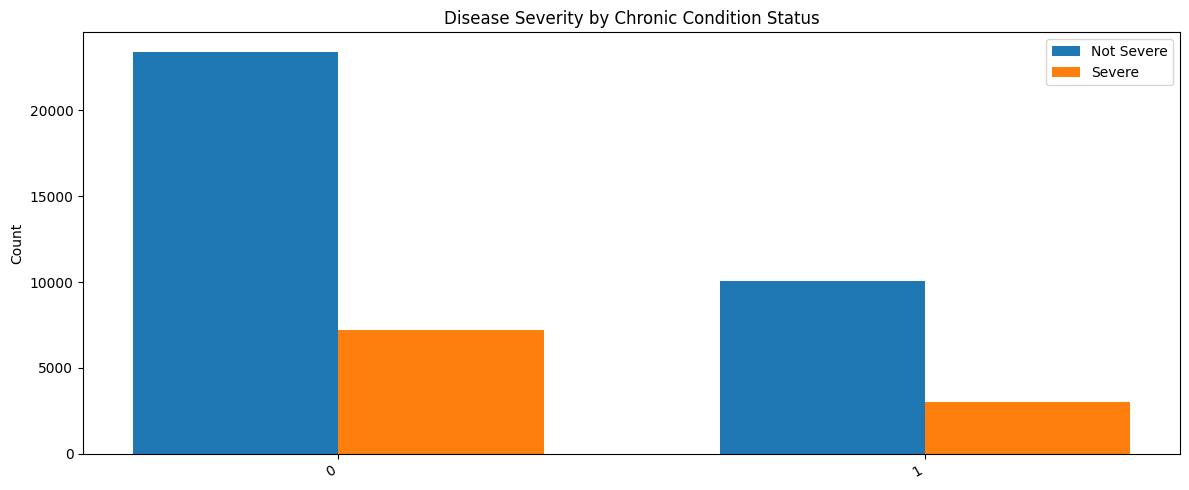

Building crosstab for: Disease Severity by Gender × Chronic Condition
[saved] /content/chronic_severity_interaction/severity_by_gender.csv
[saved] /content/chronic_severity_interaction/severity_by_gender.png


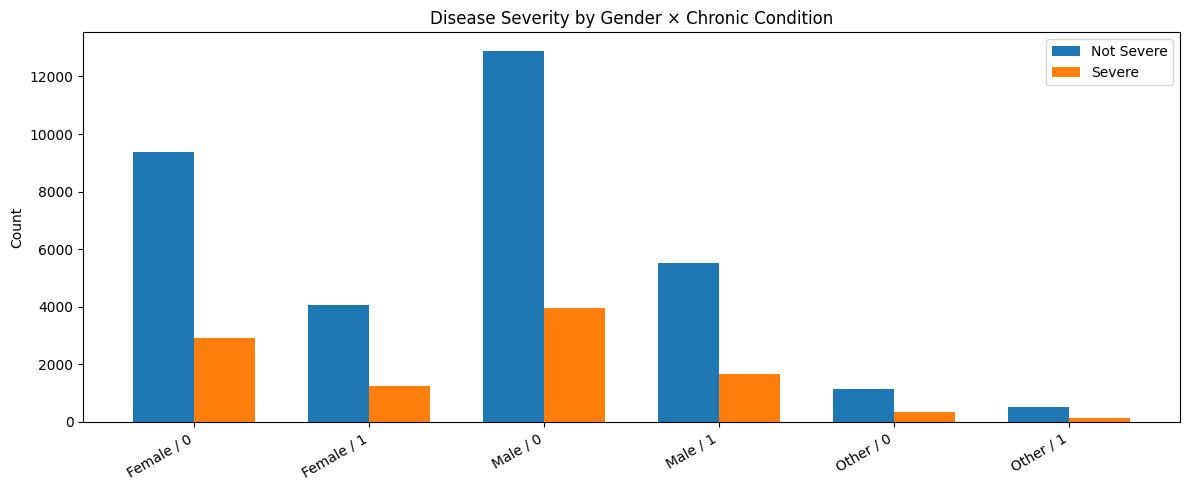

Building crosstab for: Disease Severity by Age Group × Chronic Condition
[saved] /content/chronic_severity_interaction/severity_by_agebins.csv
[saved] /content/chronic_severity_interaction/severity_by_agebins.png


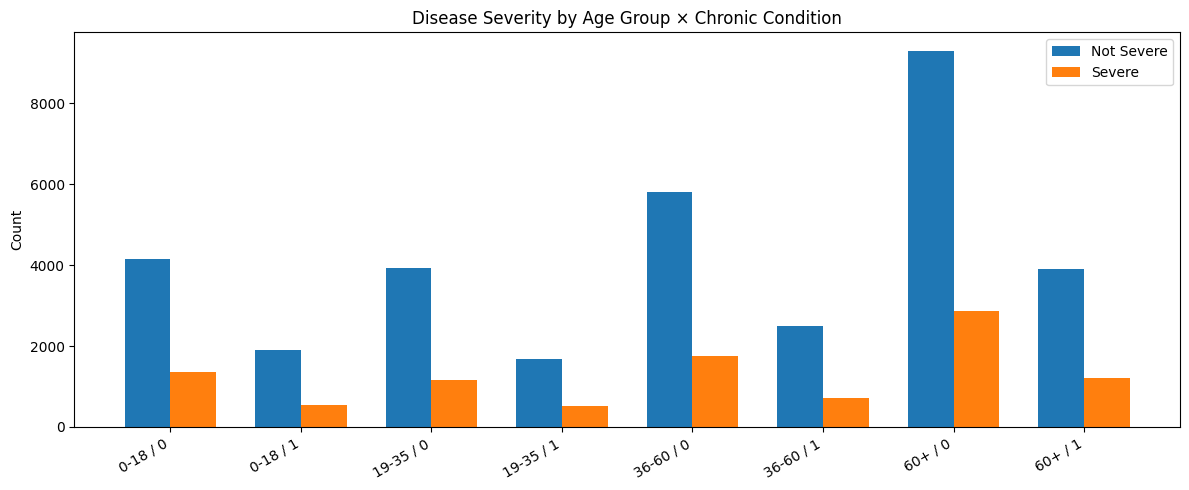

Building crosstab for: Disease Severity by SES × Chronic Condition
[saved] /content/chronic_severity_interaction/severity_by_ses.csv
[saved] /content/chronic_severity_interaction/severity_by_ses.png


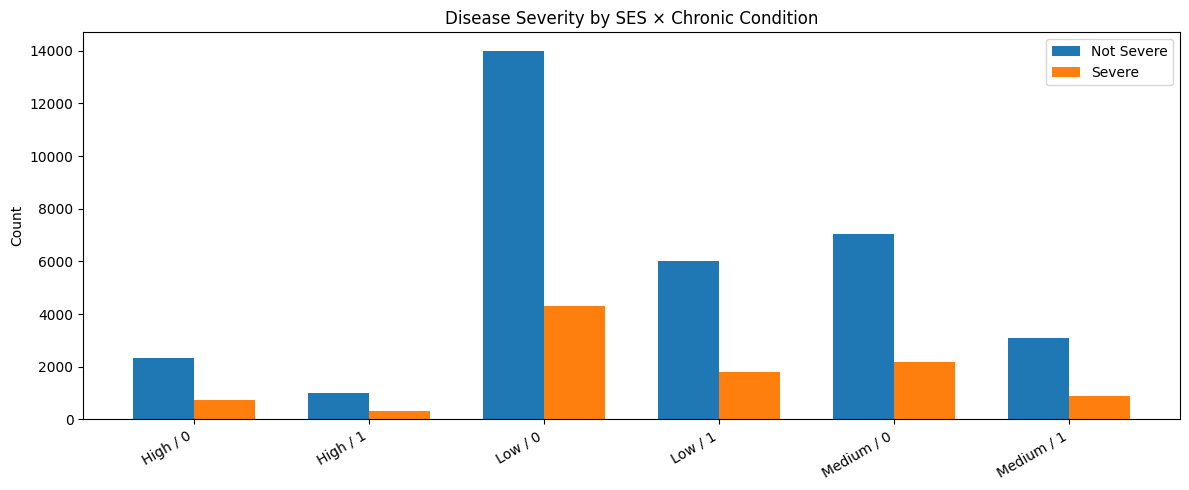

Building crosstab for: Disease Severity by Ethnicity × Chronic Condition
[saved] /content/chronic_severity_interaction/severity_by_ethnicity.csv
[saved] /content/chronic_severity_interaction/severity_by_ethnicity.png


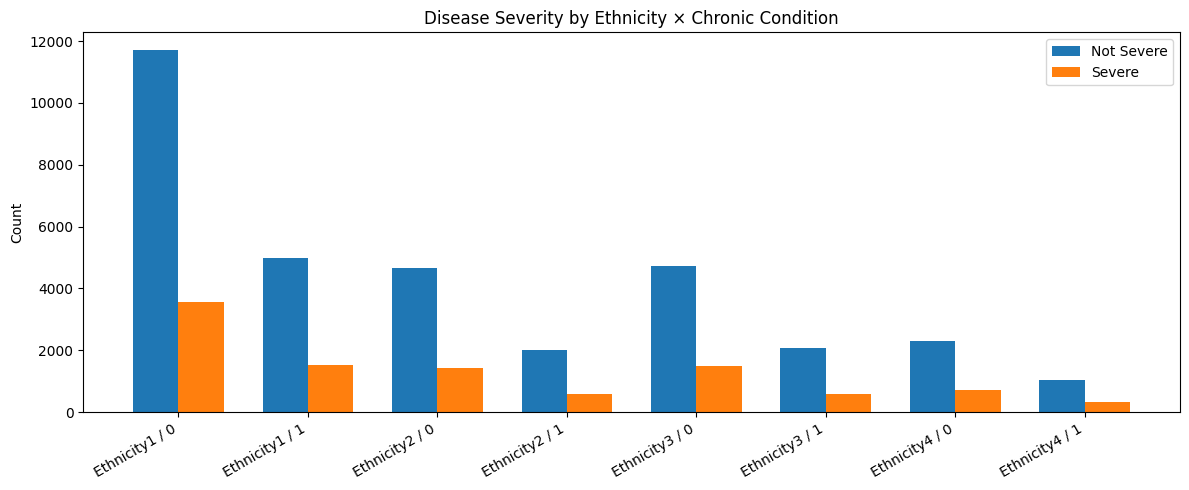

[saved] /content/chronic_severity_interaction/severity_by_location_top12.csv
[saved] /content/chronic_severity_interaction/severity_by_location_top12.png


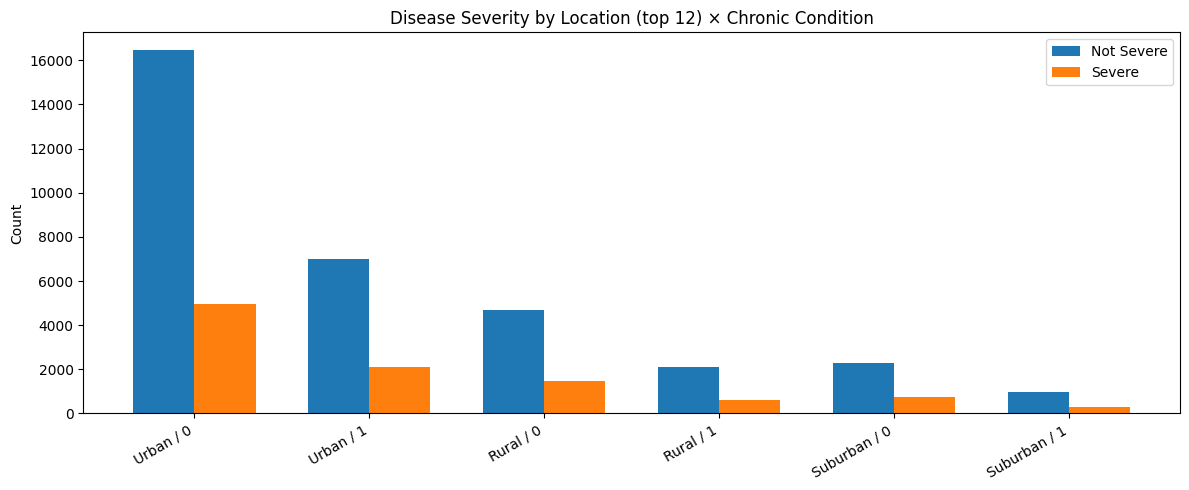


Files in output folder:
 - severity_by_agebins.csv
 - severity_by_agebins.png
 - severity_by_chronic.csv
 - severity_by_chronic.png
 - severity_by_ethnicity.csv
 - severity_by_ethnicity.png
 - severity_by_gender.csv
 - severity_by_gender.png
 - severity_by_location_top12.csv
 - severity_by_location_top12.png
 - severity_by_ses.csv
 - severity_by_ses.png

Absolute output path: /content/chronic_severity_interaction


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -------------------- CONFIG --------------------
DATA_PATH = "/content/Public health data/public_health_surveillance_dataset.csv"
OUTDIR = Path("/content/chronic_severity_interaction")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Toggle this to also display figures inline (e.g., in notebooks)
SHOW_INLINE = True
VERBOSE = True

def log(msg):
    if VERBOSE:
        print(msg)

print(f"Using dataset: {DATA_PATH}")

# -------------------- LOAD & CLEAN --------------------
df = pd.read_csv(DATA_PATH)

for col in ["SES", "Gender", "Ethnicity", "Location",
            "Chronic_Conditions", "Disease_Severity", "Hospitalization_Requirement"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

if "Age" in df.columns:
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

def text_is_none(s: str) -> bool:
    s = (s or "").strip().lower()
    return s in {"", "none", "no", "0", "nan", "null", "n/a"}

df["has_chronic"] = df["Chronic_Conditions"].apply(lambda x: 0 if text_is_none(str(x)) else 1)

df["severe_outcome"] = (
    df["Hospitalization_Requirement"].str.contains("Requires Hospitalization", case=False, na=False)
    | df["Disease_Severity"].isin(["Severe", "Critical"])
).astype(int)

log(f"Rows: {len(df):,}")
log("Columns present: " + ", ".join(df.columns))

# -------------------- HELPERS --------------------
def flatten_index(index) -> list:
    """String labels for regular or MultiIndex rows."""
    try:
        # pandas >= 1.2
        return [' / '.join(map(str, tup)) for tup in index.to_flat_index()]
    except Exception:
        # fallback
        return list(map(str, index))

def ensure_binary(ct: pd.DataFrame, binary_cols=(0, 1)) -> pd.DataFrame:
    """Ensure crosstab has both severity columns (0,1) and names are strings."""
    ct = ct.copy()
    for c in binary_cols:
        if c not in ct.columns:
            ct[c] = 0
    ct = ct[list(binary_cols)]
    ct.columns = [str(c) for c in binary_cols]
    return ct

def plot_clustered(ct: pd.DataFrame, title: str, outfile: Path, labels_map=None):
    """Clustered column chart for counts (handles MultiIndex)."""
    if ct.empty:
        log(f"[skip] Empty crosstab for: {title}")
        return

    ct = ensure_binary(ct)
    categories = flatten_index(ct.index)
    outcomes = list(ct.columns)  # ['0','1'] after ensure_binary
    x = np.arange(len(categories))
    width = 0.35 if len(outcomes) == 2 else max(0.1, 0.8 / max(1, len(outcomes)))

    plt.figure(figsize=(12, max(5, 0.4 * max(1, len(categories)))))
    for i, outcome in enumerate(outcomes):
        vals = ct[outcome].values
        label = labels_map.get(outcome, outcome) if labels_map else outcome
        plt.bar(x + i*width, vals, width, label=label)

    plt.xticks(x + width*(len(outcomes)-1)/2, categories, rotation=30, ha="right")
    plt.title(title)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()

    plt.savefig(outfile, dpi=300)
    log(f"[saved] {outfile}")
    if SHOW_INLINE:
        plt.show()
    plt.close()

def make_and_plot(title, idx, col, csv_name, png_name):
    """Generic maker for a crosstab + clustered bar with logging."""
    log(f"Building crosstab for: {title}")
    ct = pd.crosstab(idx, col)
    csv_path = OUTDIR / csv_name
    ct.to_csv(csv_path)
    log(f"[saved] {csv_path}")
    plot_clustered(ct, title, OUTDIR / png_name, labels_map={"0": "Not Severe", "1": "Severe"})

# -------------------- 1) Chronic vs Severity (overall) --------------------
make_and_plot(
    "Disease Severity by Chronic Condition Status",
    df["has_chronic"], df["severe_outcome"],
    "severity_by_chronic.csv", "severity_by_chronic.png"
)

# -------------------- 2) By Gender × Chronic --------------------
if "Gender" in df.columns:
    make_and_plot(
        "Disease Severity by Gender × Chronic Condition",
        [df["Gender"], df["has_chronic"]], df["severe_outcome"],
        "severity_by_gender.csv", "severity_by_gender.png"
    )

# -------------------- 3) By Age Group × Chronic --------------------
if "Age" in df.columns:
    bins = [0, 18, 35, 60, 120]
    labels = ["0-18", "19-35", "36-60", "60+"]
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)
    make_and_plot(
        "Disease Severity by Age Group × Chronic Condition",
        [df["AgeBin"], df["has_chronic"]], df["severe_outcome"],
        "severity_by_agebins.csv", "severity_by_agebins.png"
    )

# -------------------- 4) By SES × Chronic --------------------
if "SES" in df.columns:
    make_and_plot(
        "Disease Severity by SES × Chronic Condition",
        [df["SES"], df["has_chronic"]], df["severe_outcome"],
        "severity_by_ses.csv", "severity_by_ses.png"
    )

# -------------------- 5) By Ethnicity × Chronic --------------------
if "Ethnicity" in df.columns:
    make_and_plot(
        "Disease Severity by Ethnicity × Chronic Condition",
        [df["Ethnicity"], df["has_chronic"]], df["severe_outcome"],
        "severity_by_ethnicity.csv", "severity_by_ethnicity.png"
    )

# -------------------- 6) By Location (top 12) × Chronic --------------------
if "Location" in df.columns:
    topN = 12
    top_locs = df["Location"].value_counts().head(topN).index.tolist()
    df_top = df[df["Location"].isin(top_locs)].copy()
    # ensure both chronic states per location in saved CSV by reindexing a product
    ct_loc = pd.crosstab([df_top["Location"], df_top["has_chronic"]], df_top["severe_outcome"])
    idx_product = pd.MultiIndex.from_product([top_locs, [0, 1]], names=["Location", "has_chronic"])
    ct_loc = ct_loc.reindex(idx_product).fillna(0).astype(int)
    ct_loc.to_csv(OUTDIR / "severity_by_location_top12.csv")
    log(f"[saved] {OUTDIR / 'severity_by_location_top12.csv'}")
    plot_clustered(
        ct_loc, f"Disease Severity by Location (top {topN}) × Chronic Condition",
        OUTDIR / "severity_by_location_top12.png",
        labels_map={"0": "Not Severe", "1": "Severe"}
    )

# -------------------- LIST OUTPUTS --------------------
print("\nFiles in output folder:")
for f in sorted(os.listdir(OUTDIR)):
    print(" -", f)
print(f"\nAbsolute output path: {OUTDIR.resolve()}")
